# MACHINE LEARNING

## SETUP

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/

## CLEANING

In [9]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.executor.memory", "12g")\
    .config("spark.executor.cores", "3")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
            "fs.s3a.aws.credentials.provider",
            "com.amazonaws.auth.ContainerCredentialsProvider"
    )\
    .getOrCreate()

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0a72fff1-6a0f-413c-a4ed-44cb433aeee1;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

3.4.0


In [10]:
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler
from pyspark.sql.functions import length

### Import Data

In [5]:
%%time
bucket = "project-group34"
session = sagemaker.Session()
output_prefix_data_submissions = "project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading comments from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading comments from s3a://project-group34/project/submissions/yyyy=*


23/11/27 21:29:41 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


CPU times: user 199 ms, sys: 16.9 ms, total: 216 ms
Wall time: 6.49 s


23/11/27 21:29:47 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Data Processing

In [8]:
print(f"Shape of the submissions data is: {submissions.count()} x {len(submissions.columns)}")

Shape of the submissions data is: 875969 x 68


In [6]:
submissions = submissions.select("subreddit", "title", "selftext", "score", "num_comments", "over_18", "is_self", "is_video", "domain", "created_utc", "author", "author_flair_text", "media")

In [7]:
# Assuming your DataFrame is named `df`
submissions = submissions.withColumn('post_length', length(submissions.title) + length(submissions.selftext))

In [8]:
from pyspark.sql import functions as F

submissions = submissions.withColumn('created_utc', F.to_timestamp('created_utc'))

# Extract time-based features
submissions = submissions.withColumn('hour_of_day', F.hour('created_utc'))
submissions = submissions.withColumn('day_of_week', F.dayofweek('created_utc'))  # 1 (Sunday) to 7 (Saturday)
# Map each day of the week from numeric to string
submissions = submissions.withColumn('day_of_week_str', F.expr("""
    CASE day_of_week 
        WHEN 1 THEN 'Sunday'
        WHEN 2 THEN 'Monday'
        WHEN 3 THEN 'Tuesday'
        WHEN 4 THEN 'Wednesday'
        WHEN 5 THEN 'Thursday'
        WHEN 6 THEN 'Friday'
        WHEN 7 THEN 'Saturday'
    END
"""))
submissions = submissions.withColumn('day_of_month', F.dayofmonth('created_utc'))
submissions = submissions.withColumn('month', F.month('created_utc'))
submissions = submissions.withColumn('year', F.year('created_utc'))

submissions = submissions.withColumn('has_media', F.col('media').isNotNull())

In [9]:
submissions = submissions.drop(*["media"])

In [10]:
submissions = submissions.select('subreddit',
                                 'title',
                                 'selftext',
                                 'score',
                                 'num_comments',
                                 'over_18',
                                 'is_self',
                                 'is_video',
                                 'domain',
                                 'post_length',
                                 'hour_of_day',
                                 'day_of_week',
                                 'day_of_week_str',
                                 'day_of_month',
                                 'month',
                                 'year',
                                 'has_media')

In [11]:
# Combine 'title' and 'selftext' into a new column 'body'
submissions = submissions.withColumn("body", concat_ws(" ", col("title"), col("selftext")))


In [12]:
submissions = submissions.drop(*["title", "selftext"])

In [13]:
submissions.show(5)

+----------+-----+------------+-------+-------+--------+---------------+-----------+-----------+-----------+---------------+------------+-----+----+---------+--------------------+
| subreddit|score|num_comments|over_18|is_self|is_video|         domain|post_length|hour_of_day|day_of_week|day_of_week_str|day_of_month|month|year|has_media|                body|
+----------+-----+------------+-------+-------+--------+---------------+-----------+-----------+-----------+---------------+------------+-----+----+---------+--------------------+
|television|    0|           9|  false|   true|   false|self.television|        605|         22|          4|      Wednesday|          27|    1|2021|    false|Is there a websit...|
|     anime|    0|           3|  false|  false|   false|      i.redd.it|         50|         22|          4|      Wednesday|          27|    1|2021|    false|Does anyone know ...|
|television|    4|          11|  false|  false|   false|   deadline.com|         86|         22|    

In [31]:
from pyspark.sql.functions import col, count, when

missing_vals = submissions.select([count(when(col(c).isNull(), c)).alias(c) for c in submissions.columns])

In [32]:
missing_vals.show()

+---------+-----+------------+-------+-------+--------+------+-----------+-----------+-----------+---------------+------------+-----+----+---------+----+
|subreddit|score|num_comments|over_18|is_self|is_video|domain|post_length|hour_of_day|day_of_week|day_of_week_str|day_of_month|month|year|has_media|body|
+---------+-----+------------+-------+-------+--------+------+-----------+-----------+-----------+---------------+------------+-----+----+---------+----+
|        0|    0|           0|      0|      0|       0|  8002|          0|          0|          0|              0|           0|    0|   0|        0|   0|
+---------+-----+------------+-------+-------+--------+------+-----------+-----------+-----------+---------------+------------+-----+----+---------+----+



In [14]:
submissions = submissions.na.drop(subset=["domain"])

In [15]:
from pyspark.sql.functions import lower, regexp_replace

submissions = submissions.withColumn("body", lower(col("body")))

# Remove newline characters
submissions = submissions.withColumn("body", regexp_replace(col("body"), "\n", " "))

# Remove punctuations
submissions = submissions.withColumn("body", regexp_replace(col("body"), "[^a-zA-Z0-9\s]", ""))


In [16]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

# Tokenize text
tokenizer = Tokenizer(inputCol="body", outputCol="words")
tokenized_df = tokenizer.transform(submissions)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_no_stopwords = remover.transform(tokenized_df)

# Vectorize words
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures")
featurizedData = hashingTF.transform(df_no_stopwords)

# Optionally, use IDF to rescale the feature vectors
idf = IDF(inputCol="rawFeatures", outputCol="features")
rescaledData = idf.fit(featurizedData).transform(featurizedData)


In [17]:
rescaledData = rescaledData.drop(*["day_of_week_str", "words", "filtered_words", "rawFeatures"])

In [19]:
rescaledData.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- score: long (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- domain: string (nullable = true)
 |-- post_length: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- has_media: boolean (nullable = false)
 |-- body: string (nullable = false)
 |-- features: vector (nullable = true)



In [18]:
rescaledData.show()

23/11/27 21:34:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+----------+-----+------------+-------+-------+--------+---------------+-----------+-----------+-----------+------------+-----+----+---------+--------------------+--------------------+
| subreddit|score|num_comments|over_18|is_self|is_video|         domain|post_length|hour_of_day|day_of_week|day_of_month|month|year|has_media|                body|            features|
+----------+-----+------------+-------+-------+--------+---------------+-----------+-----------+-----------+------------+-----+----+---------+--------------------+--------------------+
|television|    0|           9|  false|   true|   false|self.television|        605|         22|          4|          27|    1|2021|    false|is there a websit...|(262144,[1546,158...|
|     anime|    0|           3|  false|  false|   false|      i.redd.it|         50|         22|          4|          27|    1|2021|    false|does anyone know ...|(262144,[101370,1...|
|television|    4|          11|  false|  false|   false|   deadline.com|   

In [19]:
rescaledData.select("features").show(1, truncate=False)

23/11/27 21:34:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
from pyspark.sql.functions import col

rescaledData = rescaledData.withColumn("over_18", col("over_18").cast("string"))
rescaledData = rescaledData.withColumn("is_self", col("is_self").cast("string"))
rescaledData = rescaledData.withColumn("is_video", col("is_video").cast("string"))
rescaledData = rescaledData.withColumn("has_media", col("has_media").cast("string"))


In [21]:
rescaledData.write.parquet("s3a://project-group34/project/submissions/cleaned_ML/", mode="overwrite")

23/11/27 21:34:13 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


## ML

### SPARK JOB

In [3]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=7200,
)

# # S3 URI of the initialization script
# s3_uri_init_script = f's3://{bucket}/{script_key}'

# s3 paths
session = sagemaker.Session()
output_prefix_logs = f"spark_logs"

configuration = [
    {
        "Classification": "spark-defaults",
        "Properties": {"spark.executor.memory": "12g", "spark.executor.cores": "4"},
    }
]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 1.4 s, sys: 495 ms, total: 1.9 s
Wall time: 1.36 s


#### RANDOM FOREST

##### PREPROCESSING JOB

In [36]:
!mkdir -p ./code

In [37]:
%%writefile ./code/preprocess_ml.py

import sys
import os
import logging
import argparse
# Import pyspark and build Spark session
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline, Model
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import length


logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    
    parser = argparse.ArgumentParser(description="app inputs and outputs")
    parser.add_argument("--s3_dataset_path", type=str, help="Path of dataset in S3")    
    args = parser.parse_args()

    spark = SparkSession.builder \
    .appName("Spark ML")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()
    
    logger.info(f"Spark version: {spark.version}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

    # Downloading the data from S3 into a Dataframe
    logger.info(f"going to read {args.s3_dataset_path}")
    rescaledData = spark.read.parquet(args.s3_dataset_path, header=True)
    vals = ["movies", "anime"]
    rescaledData = rescaledData.where(col("subreddit").isin(vals))
    
    train_data, test_data, val_data = rescaledData.randomSplit([0.8, 0.15, 0.05], seed=1220)
    
    # Print the number of records in each dataset
    logger.info("Number of training records: " + str(train_data.count()))
    logger.info("Number of testing records: " + str(test_data.count()))
    logger.info("Number of validation records: " + str(val_data.count()))
    
    stringIndexer_over_18 = StringIndexer(inputCol="over_18", outputCol="over_18_ix")
    stringIndexer_is_self = StringIndexer(inputCol="is_self", outputCol="is_self_ix")
    stringIndexer_is_video = StringIndexer(inputCol="is_video", outputCol="is_video_ix")
    stringIndexer_has_media = StringIndexer(inputCol="has_media", outputCol="has_media_ix")
    stringIndexer_subreddit = StringIndexer(inputCol="subreddit", outputCol="subreddit_ix")
    onehot_over_18 = OneHotEncoder(inputCol="over_18_ix", outputCol="over_18_vec")
    onehot_is_self = OneHotEncoder(inputCol="is_self_ix", outputCol="is_self_vec")
    onehot_is_video = OneHotEncoder(inputCol="is_video_ix", outputCol="is_video_vec")
    onehot_has_media = OneHotEncoder(inputCol="has_media_ix", outputCol="has_media_vec")
    
    vectorAssembler_features = VectorAssembler(
                                    inputCols=["features", "over_18_vec", "is_self_vec", "is_video_vec", 
                                               "has_media_vec", "score", "num_comments",
                                               "post_length", "hour_of_day", "day_of_week", 
                                               "day_of_month", "month", "year"],
                                    outputCol="combined_features")

    # Define the stages for the pipeline
    stages = [
        stringIndexer_subreddit, 
        stringIndexer_over_18, 
        stringIndexer_is_self, 
        stringIndexer_is_video, 
        stringIndexer_has_media,
        onehot_over_18,
        onehot_is_self,
        onehot_is_video,
        onehot_has_media,
        vectorAssembler_features
    ]

    # Define the pipeline without the classifier and evaluator
    pipeline = Pipeline(stages=stages)

    # Fit the preprocessing part of the pipeline
    pipeline_fit = pipeline.fit(train_data)

    # Transform the data
    transformed_train_data = pipeline_fit.transform(train_data)
    transformed_test_data = pipeline_fit.transform(test_data)
    
    transformed_train_data.write.parquet("s3a://project-group34/project/submissions/preprocessed_ML/train/")
    transformed_test_data.write.parquet("s3a://project-group34/project/submissions/preprocessed_ML/test/")
    
if __name__ == "__main__":
    main()

Overwriting ./code/preprocess_ml.py


In [38]:
%%time
bucket = "project-group34"
s3_path = "s3a://project-group34/project/submissions/cleaned_ML/"

# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/preprocess_ml.py",
    arguments=[
        "--s3_dataset_path",
        s3_path,
    ],
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)


INFO:sagemaker:Creating processing-job with name sm-spark-project-2023-11-28-04-04-56-000


.....................................................................................................!CPU times: user 359 ms, sys: 45.3 ms, total: 404 ms
Wall time: 8min 34s


##### HYPERPARAMETERS - numTrees=100, maxDepth=10, maxBins=64

In [4]:
%%writefile ./code/ml_train_RF1.py

import sys
import os
import logging
import argparse
# Import pyspark and build Spark session
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline, Model
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import length


logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():

    spark = (SparkSession.builder\
             .appName("PySparkApp")\
             .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")\
             .config(
                    "fs.s3a.aws.credentials.provider",
                    "com.amazonaws.auth.ContainerCredentialsProvider",
                )\
    .getOrCreate()
)
    
    logger.info(f"Spark version: {spark.version}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

    # Downloading the data from S3 into a Dataframe
    transformed_train_data = spark.read.parquet("s3a://project-group34/project/submissions/preprocessed_ML/train/")
    transformed_test_data = spark.read.parquet("s3a://project-group34/project/submissions/preprocessed_ML/test/")
    
    # RandomForestClassifier without hyperparameter tuning
    rf_classifier = RandomForestClassifier(labelCol="subreddit_ix", 
                                           featuresCol="combined_features", 
                                           numTrees=100, 
                                           maxDepth=10,
                                           maxBins=64)
    labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedSubreddit", 
                               labels=["anime", "movie"])

    # Add the best model and labelConverter to the pipeline
    pipeline = Pipeline(stages=[rf_classifier, 
                                labelConverter])
    
    # Fit the entire pipeline
    pipeline_fit = pipeline.fit(transformed_train_data)
    train_predictions = pipeline_fit.transform(transformed_train_data)

    # Transform the data with the best model
    test_predictions = pipeline_fit.transform(transformed_test_data)
    
    train_predictions.write.parquet("s3a://project-group34/project/submissions/RandomForest/numTrees=100_maxDepth=10_maxBins=64/train_pred/", mode="overwrite")    
    test_predictions.write.parquet("s3a://project-group34/project/submissions/RandomForest/numTrees=100_maxDepth=10_maxBins=64/test_pred/", mode="overwrite")
    pipeline_fit.save("s3a://project-group34/project/submissions/RandomForest/numTrees=100_maxDepth=10_maxBins=64/model/")
    
    logger.info(f"all done...")
    
if __name__ == "__main__":
    main()

Writing ./code/ml_train_RF1.py


In [5]:
%%time
bucket = "project-group34"

# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/ml_train_RF1.py",
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)


INFO:sagemaker:Creating processing-job with name sm-spark-project-2023-11-28-23-33-31-511


....................................................................................................................................................................................................................................................................................................................................................................................................................!CPU times: user 1.44 s, sys: 106 ms, total: 1.54 s
Wall time: 34min


### EVALUATION

In [7]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.executor.memory", "12g")\
    .config("spark.executor.cores", "3")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
            "fs.s3a.aws.credentials.provider",
            "com.amazonaws.auth.ContainerCredentialsProvider"
    )\
    .getOrCreate()

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-44cfc8f4-0d72-42cd-b2e6-85ad56853759;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

3.4.0


In [8]:
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler
from pyspark.sql.functions import length

In [9]:
transformed_train = spark.read.parquet("s3a://project-group34/project/submissions/RandomForest/numTrees=100_maxDepth=10_maxBins=64/train_pred/")

23/11/29 00:09:52 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [10]:
transformed_test = spark.read.parquet("s3a://project-group34/project/submissions/RandomForest/numTrees=100_maxDepth=10_maxBins=64/test_pred/")

In [12]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [13]:
evaluator = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(transformed_train)

In [14]:
accuracy

0.7606373594649645

In [15]:
evaluator = MulticlassClassificationEvaluator(labelCol="subreddit_ix", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(transformed_test)

In [16]:
accuracy

0.7598409067631696

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
y_pred = [row['prediction'] for row in transformed_test.select("prediction").collect()]
y_orig = [row['subreddit_ix'] for row in transformed_test.select("subreddit_ix").collect()]

In [19]:
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[59703   568]
 [27570 29323]]


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

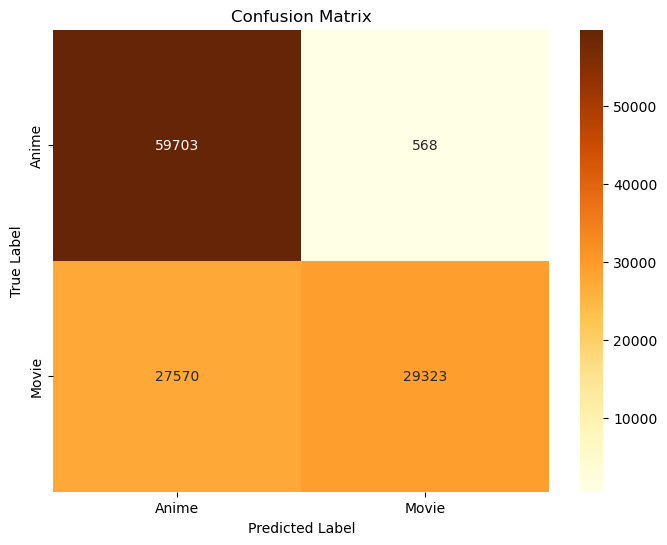

In [24]:
# Plot using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap=sns.color_palette("YlOrBr", as_cmap=True), yticklabels=["Anime", "Movie"], xticklabels=["Anime", "Movie"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()